In [41]:
import numpy as np
from sympy.geometry import Point,Circle,Segment,intersection,Line
import matplotlib.pyplot as plt
from matplotlib.patches import Arc as Arc_patch
from matplotlib import collections  as mc
import time


In [48]:
class Arc:
    def __init__(self,r,theta1,theta2,origin = (0,0)):
        x,y = origin
        self.x = x
        self.y = y
        self.r = r
        self.origin = origin
        self.theta1 = theta1
        self.theta2 = theta2
        self.endpoints = [Point(self.x+r*np.cos(theta1),self.y+r*np.sin(theta1)),Point(self.x+r*np.cos(theta2),self.y+r*np.sin(theta2))]
        self.circle = Circle(Point(x,y),r)  
        
    def __contains__(self,point):
        xp,yp = float(point.x)-self.x,float(point.y)-self.y
        rot = np.array([[np.cos(self.theta1),-1*np.sin(self.theta1)],
                        [np.sin(self.theta1),np.cos(self.theta1)]])
        xp,yp = np.array([xp,yp]) @ rot
        theta = np.arctan2(yp,xp) if (yp>=0 or (self.theta1<=0 and self.theta2>=0)) else 2*np.pi + np.arctan2(yp,xp)
        return (theta>=0 and theta<=self.theta2-self.theta1) or (theta>=self.theta2-self.theta1 and theta<=0)

    def draw(self,ax,color):
        ax.add_patch(Arc_patch((self.x, self.y), 2*self.r,2*self.r, theta1=np.rad2deg(self.theta1), theta2=np.rad2deg(self.theta2), linewidth=1, color=color))       
 

In [3]:
#intersections
def arc_arc(gamma2,gamma2prime):
    eta,etaprime = gamma2.circle,gamma2prime.circle
    intersect = intersection(eta,etaprime)
    pts = []
    if len(intersect) > 0:
        if intersect[0] in gamma2 and intersect[0] in gamma2prime:
            pts.append(intersect[0])
    if len(intersect) > 1:
        if intersect[1] in gamma2 and intersect[1] in gamma2prime:
            pts.append(intersect[1])    
        
    return pts

def line_line(l1,l2):
    return intersection(l1,l2)

def line_arc(l1prime,gamma2):
    intersect = intersection(l1prime,gamma2.circle)
    pts = []
    if len(intersect)>0:
        if intersect[0] in gamma2:
            pts.append(intersect[0])
    if len(intersect)>1:
        if intersect[1] in gamma2:
            pts.append(intersect[1]) 
    return pts        
        

In [55]:
class Interval:
    """
    Defined by r1,r2,theta1,theta2 and the origin.
    r1<r2 and theta1<theta2
    """
    def __init__(self,r1,r2,theta1,theta2,origin=(0,0)):
        
        not_zero = lambda x: x if x != 0.0 else 1e-6    
        r1,r2,theta1,theta2 =  list(map(not_zero,[r1,r2,theta1,theta2]))  
        
        self.r1 = r1
        self.r2 = r2  
        self.theta1 = theta1
        self.theta2 = theta2
        x,y = origin
        self.origin = origin
        self.x = x
        self.y = y
        self.gamma1 = Arc(r1,theta1,theta2,origin=origin)
        self.gamma2 = Arc(r2,theta1,theta2,origin=origin)
        self.l1 = Segment((x+r1*np.cos(theta1),y+r1*np.sin(theta1)),(x+r2*np.cos(theta1),y+r2*np.sin(theta1)))
        self.l2 = Segment((x+r1*np.cos(theta2),y+r1*np.sin(theta2)),(x+r2*np.cos(theta2),y+r2*np.sin(theta2)))
        self.l = [self.l1,self.l2]
        self.gamma = [self.gamma1,self.gamma2]

    def __contains__(self,point):
        r = np.linalg.norm(np.array([float(point.x),float(point.y)])-np.array(self.origin))
        return (r<=self.r2 and r>=self.r1) and (point in self.gamma1)    
    
    def __repr__(self):
        return f"Interval({self.r1},{self.r2},{self.theta1},{self.theta2},{self.origin})"
    
    def draw(self,ax,color):
        try:
            l11, l12 = tuple(self.l1.points[0]),tuple(self.l1.points[1])
            l21, l22 = tuple(self.l2.points[0]),tuple(self.l2.points[1])
            lc = mc.LineCollection([[l11,l12],[l21,l22]], colors = color, linewidths=1)
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            ax.add_collection(lc) 
            
        except AttributeError:
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
    
    def general_inclusion(self,Iprime):
        I = self
        test_pts = []
        O = Point(I.origin)
        D = np.linalg.norm(np.array(I.origin)-np.array(Iprime.origin))
        if D>I.r2 + Iprime.r2:
            return Interval(0,0,0,0,I.origin),[]



        for gmp in Iprime.gamma:
            for gmi in I.gamma:
                pts = arc_arc(gmi,gmp)
                test_pts += pts    
            for li in I.l:
                pts = line_arc(li,gmp)
                test_pts += pts 
            if D<=I.r2 + Iprime.r2:
                normal_line = Line(I.origin,Iprime.origin)
                normal_points = gmp.circle.intersection(normal_line)
                for foot_normal in normal_points:
                    if foot_normal in gmp:
                        if foot_normal in I:
                            test_pts += [foot_normal]
            if D**2<=I.r2**2 + Iprime.r2**2:                
                for line in gmp.circle.tangent_lines(O):
                    tangent_pt = line.points[1]
                    if tangent_pt in gmp:
                        if tangent_pt in I:
                            test_pts += [tangent_pt]    
        for lp in Iprime.l:
            for gmi in I.gamma:
                pts = line_arc(lp,gmi)
                test_pts += pts    
            for li in I.l:
                test_pts += line_line(li,lp) 
            base_perpendicular = lp.perpendicular_segment(O).points[1]
            if lp.contains(base_perpendicular):
                if base_perpendicular in I:
                    test_pts += [base_perpendicular]    


        for point in Iprime.gamma2.endpoints+Iprime.gamma1.endpoints:
            if point in I:
                test_pts+= [point]
        if not test_pts:
            return Interval(0,0,0,0,I.origin),[]
        def cart2pol(pt):
            x,y = float(pt.x),float(pt.y)
            xi,yi = np.array([x,y])-np.array(I.origin)
            rho = np.linalg.norm(np.array([xi,yi]))
            phi = np.arctan2(yi,xi) if (yi>=0 or (I.theta1<=0 and I.theta2>=0)) else 2*np.pi + np.arctan2(yi,xi)
            return [rho, phi]
        rad_pts = np.array(list(map(cart2pol,test_pts)))
        R = rad_pts[:,0]
        THETA = rad_pts[:,1]
        rmax,rmin = max(R),min(R)
        thetamax,thetamin = max(THETA),min(THETA)
        return Interval(rmin,rmax,thetamin,thetamax,I.origin),test_pts
        

In [8]:
def clipped(I,J):
    if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
            return I
    return Interval(I.r1,J.r1,J.theta1,J.theta2,I.origin)

computation time =  1.391427993774414


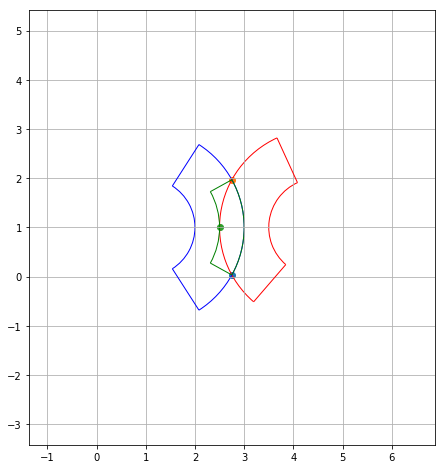

In [54]:
I2 = Interval(1,2,2,4,origin=(4.5,1))
I1 = Interval(1,2,-1,1,origin=(1,1))
# I2 = Interval(1,2,2,3.1,origin=(0.5,1))
# I1 = Interval(1,2,0.5,1.7,origin=(0,0))
# I2 = Interval(1,2,3,4.5,origin=(2,3))
# I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
#J,test_pts = general_inclusion(I1,I2)
J,test_pts = I1.general_inclusion(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
# ax1 = fig.add_subplot(1,2,2)
J.draw(ax,'green')
#clipped(I1,J).draw(ax,'magenta')
for test_pt in test_pts:
    ax.scatter(test_pt[0],test_pt[1])
# I2.draw(ax1,'red')
# I1.draw(ax1,'blue')
# plt.axis('equal')
# plt.grid()
plt.show()

In [6]:
class Interval:
    """
    Defined by r1,r2,theta1,theta2 and the origin.
    r1<r2 and theta1<theta2
    """
    def __init__(self,r1,r2,theta1,theta2,origin=(0,0)):
        
        not_zero = lambda x: x if x != 0.0 else 1e-6    
        r1,r2,theta1,theta2 =  list(map(not_zero,[r1,r2,theta1,theta2]))  
        
        self.r1 = r1
        self.r2 = r2  
        self.theta1 = theta1
        self.theta2 = theta2
        x,y = origin
        self.origin = origin
        self.x = x
        self.y = y
        self.gamma1 = Arc(r1,theta1,theta2,origin=origin)
        self.gamma2 = Arc(r2,theta1,theta2,origin=origin)
        self.l1 = Segment((x+r1*np.cos(theta1),y+r1*np.sin(theta1)),(x+r2*np.cos(theta1),y+r2*np.sin(theta1)))
        self.l2 = Segment((x+r1*np.cos(theta2),y+r1*np.sin(theta2)),(x+r2*np.cos(theta2),y+r2*np.sin(theta2)))
        self.l = [self.l1,self.l2]
        self.gamma = [self.gamma1,self.gamma2]

    def __contains__(self,point):
        r = np.linalg.norm(np.array([float(point.x),float(point.y)])-np.array(self.origin))
        return (r<=self.r2 and r>=self.r1) and (point in self.gamma1)    
    
    def __repr__(self):
        return f"Interval({self.r1},{self.r2},{self.theta1},{self.theta2},{self.origin})"
    
    def draw(self,ax,color):
        try:
            l11, l12 = tuple(self.l1.points[0]),tuple(self.l1.points[1])
            l21, l22 = tuple(self.l2.points[0]),tuple(self.l2.points[1])
            lc = mc.LineCollection([[l11,l12],[l21,l22]], colors = color, linewidths=1)
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            ax.add_collection(lc) 
            
        except AttributeError:
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            
    def general_inclusion(self,Iprime):
        test_pts = []
        O = Point(self.origin)
        D = np.linalg.norm(np.array(self.origin)-np.array(Iprime.origin))
        if D>self.r2 + Iprime.r2:
            return Interval(0,0,0,0,self.origin)



        for gmp in Iprime.gamma:
            for gmi in self.gamma:
                pts = arc_arc(gmi,gmp)
                test_pts += pts    
            for li in self.l:
                pts = line_arc(li,gmp)
                test_pts += pts 
            if D<=self.r2 + Iprime.r2:
                for line in gmp.circle.normal_lines(O):
                    base_normal = line.points[0]
                    if base_normal in gmp:
                        if base_normal in self:
                            test_pts += [base_normal]
            if D**2<=self.r2**2 + Iprime.r2**2:                
                for line in gmp.circle.tangent_lines(O):
                    tangent_pt = line.points[1]
                    if tangent_pt in gmp:
                        if tangent_pt in self:
                            test_pts += [tangent_pt]    
        for lp in Iprime.l:
            for gmi in self.gamma:
                pts = line_arc(lp,gmi)
                test_pts += pts    
            for li in self.l:
                test_pts += line_line(li,lp) 
            base_perpendicular = lp.perpendicular_segment(O).points[1]
            if base_perpendicular in self:
                test_pts += [base_perpendicular]    


        for point in Iprime.gamma2.endpoints+Iprime.gamma1.endpoints:
            if point in self:
                test_pts+= [point]
        if not test_pts:
            return Interval(0,0,0,0,self.origin)
        rad_pts = np.array(list(map(cart2pol,test_pts)))
        R = rad_pts[:,0]
        THETA = rad_pts[:,1]
        rmax,rmin = max(R),min(R)
        thetamax,thetamin = max(THETA),min(THETA)
        return Interval(rmin,rmax,thetamin,thetamax,self.origin)
    
    def clip(self,J):
        if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
            return self
        return Interval(self.r1,J.r1,J.theta1,J.theta2,self.origin)
                    

In [18]:
class Robot:
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        
    @property
    def interval(self):
        theta11 = self.yaw - (self.wi - self.wj)*self.Δt
        theta21 = self.yaw + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta11)+np.cos(theta21))/(1e-6 + np.sin(theta11-theta21)),
                       self.y_bot+self.radius*(np.sin(theta11)+np.sin(theta21))/(1e-6 + np.sin(theta11-theta21)))

        n = self.radius/np.sin(1e-6+(theta21-theta11)/2)
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        theta1 = min(theta11,theta21)
        theta2 = max(theta11,theta21)
        return Interval(nu1,nu2,theta1,theta2,origin)
    
    def __repr__(self):
        return f"Robot at {self.x_bot},{self.y_bot},{self.yaw}"
    
    def set_path(self,path):
        self.path = path
    
    def collision_detection(self):
        Js = []        
        for obstacle in self.obstacles:
            I = self.interval
            J = I.general_inclusion(obstacle)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J       
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.ceil(((self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+   
            vws.append([v,-1*w])
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,traj_v,traj_w,ax):
        """
        gives good v,w given bad v,w from the tracker
        """
        I = self.interval
        vws = self.generate_vw()
        clips = set()
        if not len(Js) == 0:
            
            for J in Js:
                clips.add(I.clip(J)) 
                J.draw(ax,'green')
            for clip in clips:
                clip.draw(ax,'magenta')
                if clip.r2 == I.r2:
                    continue
                else:    
                    for i,[v,w] in enumerate(vws):
                        if self.yaw+w*self.Δt<= clip.theta2+np.arcsin(self.radius/(I.r2-self.radius))+2*np.pi/24 and self.yaw+w*self.Δt>=clip.theta1-np.arcsin(self.radius/(I.r2-self.radius))-2*np.pi/24:
                            #np.pi/24 is min angle
                            vnew = ((clip.r2-clip.r1-2*self.radius)/self.Δt)
                            if v>vnew and vnew>=0:
                                vws[i][0] = vnew
            vwes = np.array(vws)[::-1]
            is_collide = True
            v_max,ws = vwes[np.argmax(vwes[:,0])]            
            vwn = np.array([v_max/2,ws])

        else:
            max_w = abs(self.wi-self.wj)
            traj_w = traj_w if abs(traj_w)<max_w else max_w*np.sign(traj_w)
            vwn = np.array([traj_v,traj_w])
            is_collide = False        
        return vwn,is_collide

    
    def next_bot(self,traj_v,traj_w,ax):
        Js = self.collision_detection()
        vw,is_collide = self.collision_avoidance(Js,traj_v,traj_w,ax)
        v,w = vw
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        return self,is_collide
    
    def next_bots(self,ax):
        bots = []
        Js = self.collision_detection()
        for [v,w] in self.collision_avoidance(Js,ax):
            yaw = self.yaw + w*self.Δt
            x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
            y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
            bots.append(Robot(x_bot,y_bot,yaw,self.vi,self.vj,self.wi,self.wj))

        return bots
    
    
    def next_pose(self,v,w):
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        return self
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        self.interval.draw(ax,self.color)
        
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
       

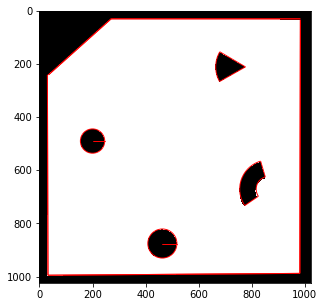

In [8]:
import cv2
import json
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)
for obstacle in obstacles:
    obstacle.draw(ax,'red')
plt.show()

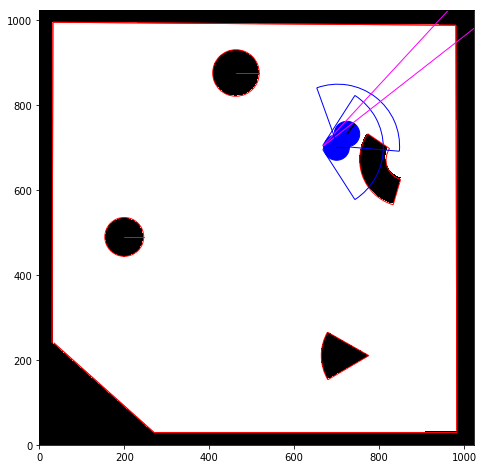

In [19]:

robot = Robot(700,700,0,80,0,1,0)

robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
    obstacle.draw(ax,'red')

robot.plot(ax)
robot.plot_interval(ax)

for i in range(1):

    
    pose,is_coll = robot.next_bot(80,1,ax)

    
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose

In [42]:
I2 = Interval(1,2,3,4.5,origin=(2,3.3))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()

AttributeError: 'Interval' object has no attribute 'fast_analysis'

computation time =  4.124319553375244


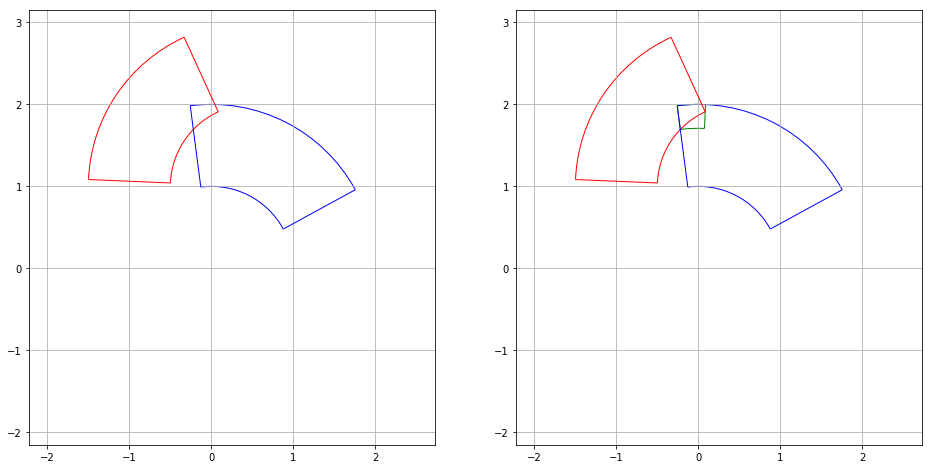

In [75]:
I2 = Interval(1,2,2,3.1,origin=(0.5,1))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()

computation time =  2.346081256866455


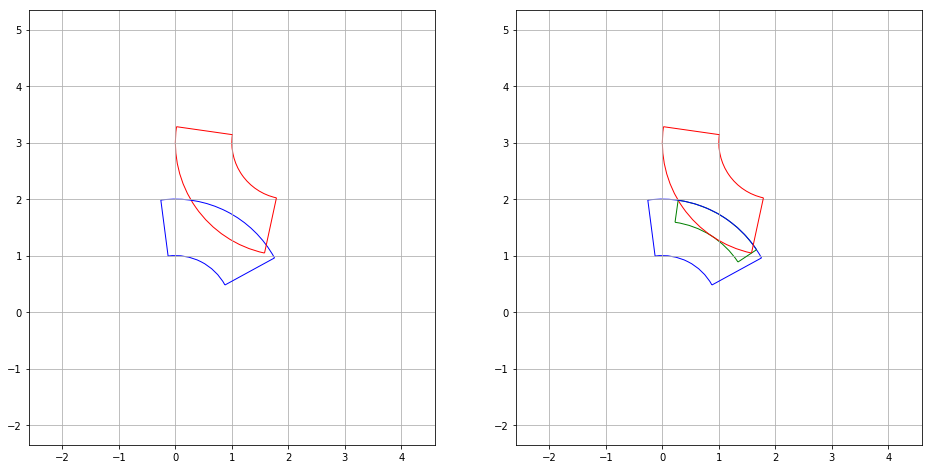

In [9]:
I2 = Interval(1,2,3,4.5,origin=(2,3))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()

########################### catch exception

computation time =  2.6673672199249268


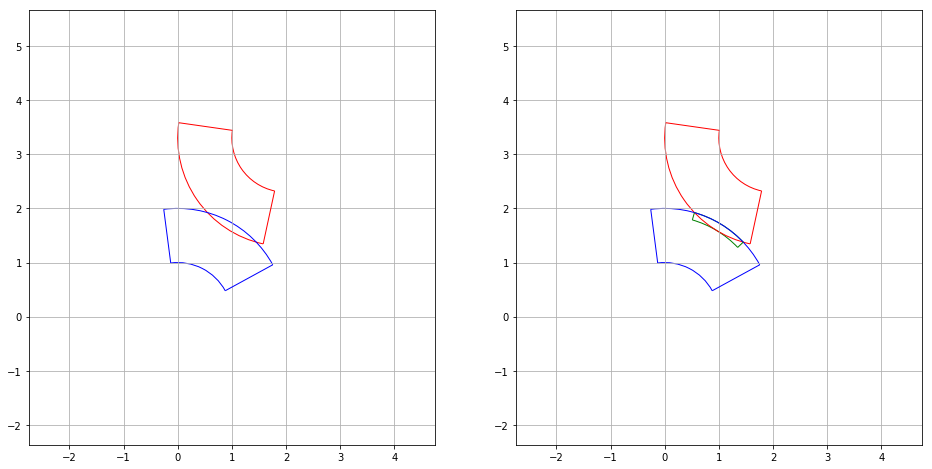

In [77]:
I2 = Interval(1,2,3,4.5,origin=(2,3.3))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  3.300509214401245


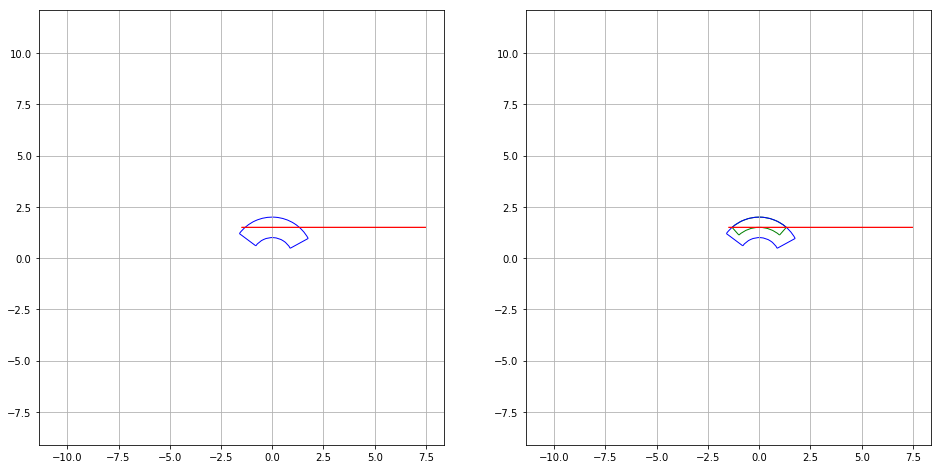

In [115]:
I2 = Interval(9,0.0+1e-6,1e-6,1e-6,origin=(-1.5,1.5))
I1 = Interval(1,2,0.5,2.5,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  3.3185410499572754


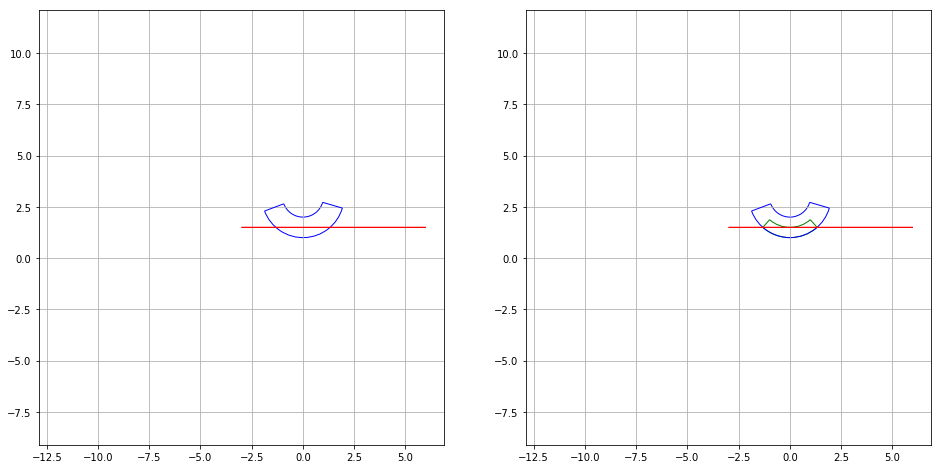

In [114]:
I2 = Interval(9,0.0+1e-6,1e-6,1e-6,origin=(-3,1.5))
I1 = Interval(1,2,3.5,6,origin=(0,3))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  3.973001480102539


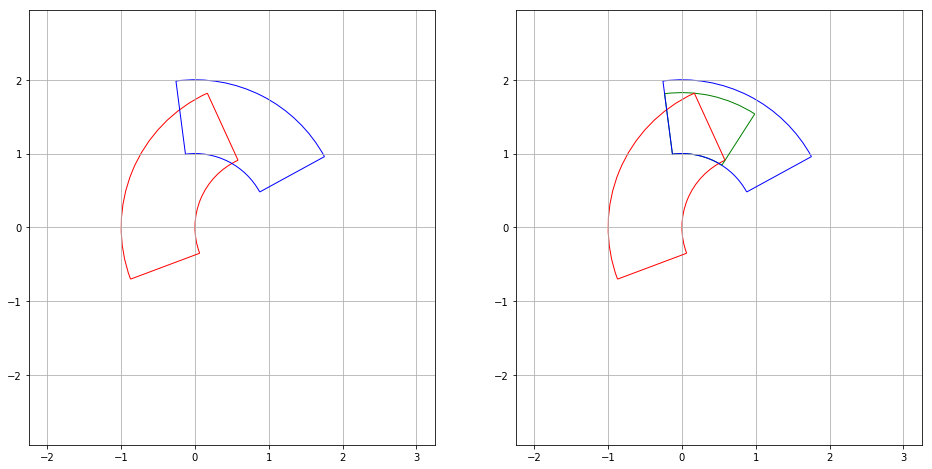

In [35]:
I2 = Interval(1,2,2,3.5,origin=(1,0))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  2.409571409225464


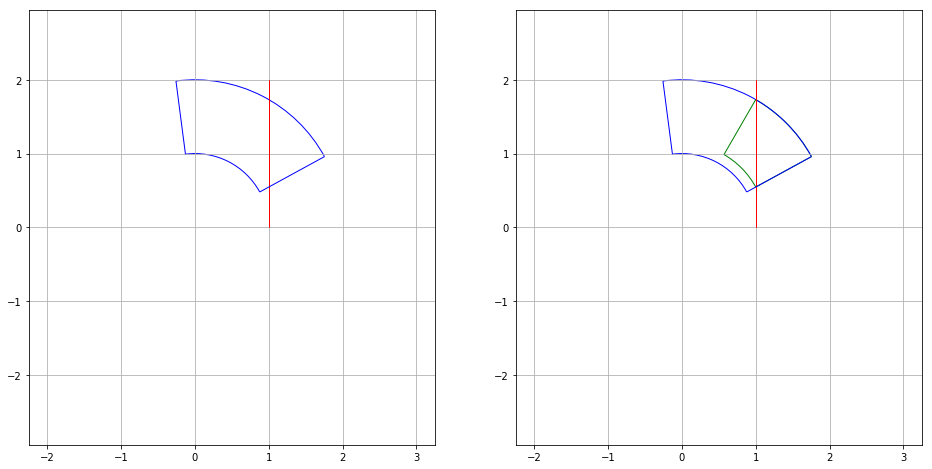

In [105]:
I2 = Interval(1e-6,2,np.pi/2,np.pi/2,origin=(1,0))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  2.7888498306274414


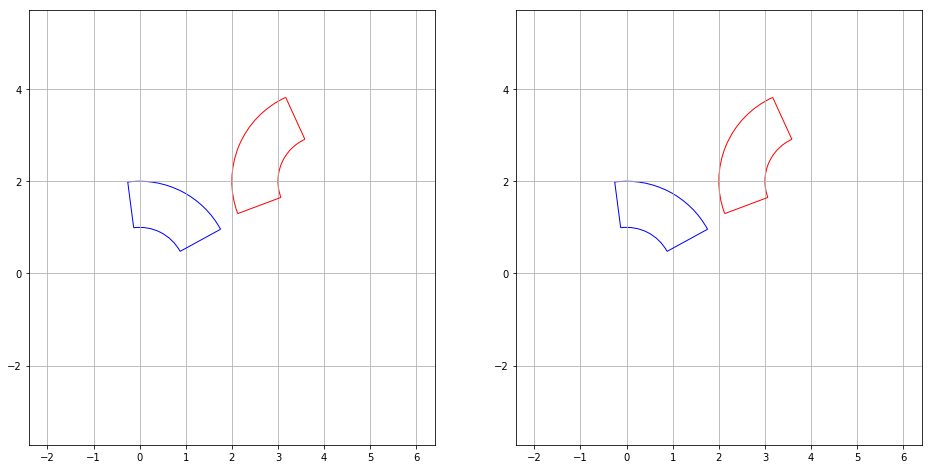

In [104]:
I2 = Interval(1,2,2,3.5,origin=(4,2))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  2.8609228134155273


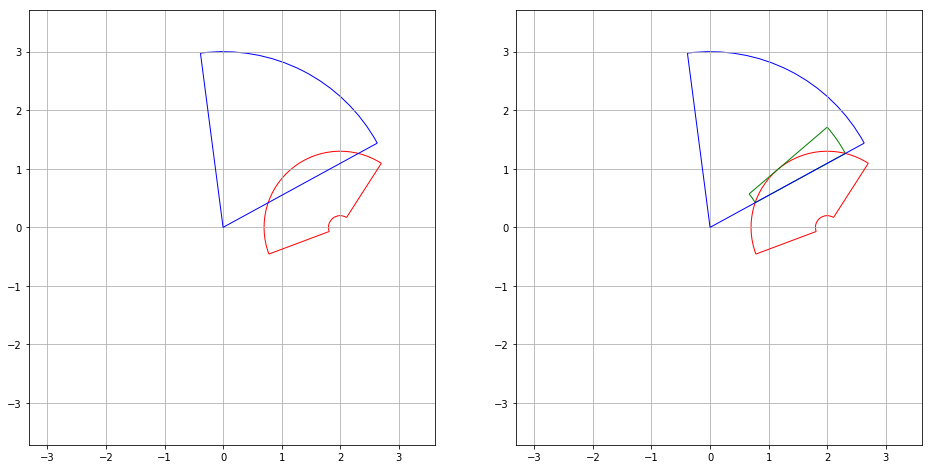

In [103]:
I2 = Interval(0.2,1.3,1,3.5,origin=(2,0))
I1 = Interval(0,3,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  3.1046581268310547


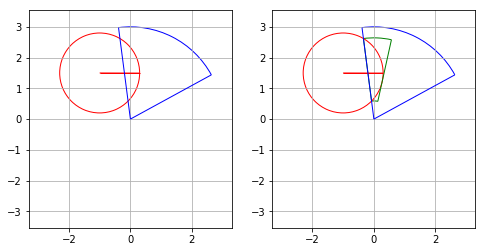

In [102]:
I2 = Interval(0,1.3,0,6.28,origin=(-1,1.5))
I1 = Interval(0,3,0.5,1.7,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
fig= plt.figure(figsize = (8,4))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



In [7]:
class Interval:
    def __init__(self,r1,r2,theta1,theta2,origin=(0,0)):
        
        if r1>r2:
            r1,r2 = r2,r1
        
        if theta1>theta2:
            theta1,theta2 = theta2,theta1
            
        not_zero = lambda x: x if x != 0.0 else 1e-6    
        r1,r2,theta1,theta2 =  list(map(not_zero,[r1,r2,theta1,theta2]))  
        
        self.r1 = r1
        self.r2 = r2  
        self.theta1 = theta1
        self.theta2 = theta2
        x,y = origin
        self.origin = origin
        self.x = x
        self.y = y
        self.gamma1 = Arc(r1,theta1,theta2,origin=origin)
        self.gamma2 = Arc(r2,theta1,theta2,origin=origin)
        self.l1 = Segment((x+r1*np.cos(theta1),y+r1*np.sin(theta1)),(x+r2*np.cos(theta1),y+r2*np.sin(theta1)))
        self.l2 = Segment((x+r1*np.cos(theta2),y+r1*np.sin(theta2)),(x+r2*np.cos(theta2),y+r2*np.sin(theta2)))
        self.l = [self.l1,self.l2]
        self.gamma = [self.gamma1,self.gamma2]

    def __contains__(self,point):
        r = np.linalg.norm(np.array((float(point.x),float(point.y)))-np.array(self.origin))
        return (r<=self.r2 and r>=self.r1) and self.gamma1.encloses(point)    
    
    def __repr__(self):
        return f"Interval({self.r1},{self.r2},{self.theta1},{self.theta2},{self.origin})"
    
    def draw(self,ax,color):
        try:
            l11, l12 = tuple(self.l1.points[0]),tuple(self.l1.points[1])
            l21, l22 = tuple(self.l2.points[0]),tuple(self.l2.points[1])
            lc = mc.LineCollection([[l11,l12],[l21,l22]], colors = color, linewidths=1)
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            ax.add_collection(lc) 
            
        except AttributeError:
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
    def fast_analysis(self,Iprime):
        def cart2pol(pt):
            x,y = float(pt.x),float(pt.y)
            xi,yi = np.array([x,y])-np.array(self.origin)
            rho = np.linalg.norm(np.array([xi,yi]))
            phi = np.arctan2(yi,xi) if yi>=0 else 2*np.pi + np.arctan2(yi,xi)
            return [rho, phi]
        def expts(**kwargs):
            if 'gamma' in kwargs and 'gammaprime' in kwargs:
                gamma = kwargs['gamma']
                gammaprime = kwargs['gammaprime']
                d = np.linalg.norm(np.array(gamma.origin)-np.array(gammaprime.origin))
                if d >= gamma.r:
                    rmin = d - gammaprime.r
                    return [[rmin],[]]
                else:
                    thetae = []
                    rmin = d - gammaprime.r
                    phi = cart2pol(Point(Iprime.origin))[1]
                    thi = np.arcsin(gammaprime.r/d)
                    if (phi+thi>=self.theta1 and phi+thi<=self.theta2):
                        thetae.append((phi + thi )) 
                    if (phi-thi>=self.theta1 and phi-thi<=self.theta2):
                        thetae.append((phi - thi)) 
              
                    return [[rmin],thetae]
                    
                return [[],[]]
            if 'l' in kwargs and 'gammaprime' in kwargs:
                l = kwargs['l']
                gammaprime = kwargs['gammaprime']
                d = np.linalg.norm(np.array(self.origin)-np.array(gammaprime.origin))
                phi = cart2pol(Point(Iprime.origin))[1]
                thi = np.arcsin(gammaprime.r/d)
                thetae = phi + thi*(1 if (phi+thi>=self.theta1 and phi+thi<=self.theta2) else -1)
                return [thetae]
            if 'gamma' in kwargs and 'lprime' in kwargs:
                lprime = kwargs['lprime']
                gamma = kwargs['gamma']
                seg = Segment(*intersection(lprime,gamma.circle))
                return [seg.midpoint]
            
        def correction(thetas):
            tuts = []
            for theta in thetas:
                if theta>=0 and theta<= np.pi/2:
                    tuts.append(0)
                if theta>=3*np.pi/2 and theta<= 2*np.pi:
                    tuts.append(1)

            if any(tuts) and not all(tuts):
                return [(theta-2*np.pi if theta>=3*np.pi/2 else theta) for theta in thetas]
            else:
                return thetas

        rs = []
        thetas = []
        test_pts = []
        num_log = np.zeros((4,4)).astype('int')

        for gmi in self.gamma:
            for gmp in Iprime.gamma:
                pts = arc_arc(gmi,gmp)
                if len(pts) == 2:
                    expt = expts(gamma=gmi,gammaprime=gmp)
                    rs += expt[0]
                    thetas += expt[1]
                num_log[i,j] = len(pts)    
                test_pts += pts    
            for lp in Iprime.l:
                pts = line_arc(lp,gmi)
                if len(pts) == 2:
                    test_pts += expts(lprime=lp,gamma=gmi)
                test_pts += pts 
                num_log[i,j+2] = len(pts)
        for li in self.l:
            for gmp in Iprime.gamma:
                pts = line_arc(li,gmp)
                if len(pts)==2:
                    thetas += expts(l=li,gammaprime=gmp) 
                test_pts += pts   
                num_log[i+2,j] = len(pts)
            for lp in Iprime.l:
                pts = line_line(li,lp) 
                test_pts += pts
                num_log[i+2,j+2] = len(pts)
#         for i in range(2):
#             if (num_log[1,i+2] == 1 and num_log[2,i+2] == 1):
#                 pt1 = intersection(self.l[0],Iprime.l[0])
#                 pt2 = intersection(self.l[0],Iprime.l[0])
#                 gammax = Arc(r,theta1,theta2,self.origin)
        if self.gamma2.encloses(Point(Iprime.origin)) and Iprime.gamma2.encloses(Point(self.origin)):
            expt = expts(gamma=self.gamma2,gammaprime=Iprime.gamma2)
            rs += expt[0]
            thetas += expt[1]
            
        ###### consider the corners of [I'] in [I]    
        for point in Iprime.gamma2.endpoints+Iprime.gamma1.endpoints:
            if point in self:
                test_pts+= [point]

        rad_pts = np.array(list(map(cart2pol,test_pts)))
        if len(rad_pts) == 0:
            return Interval(0,0,0,0,self.origin)
        
        radii = list(rad_pts[:,0]) + rs
        
        thetas = correction(list(rad_pts[:,1])) + thetas
        rmax,rmin = max(radii),min(radii)
        thetamax,thetamin = max(thetas),min(thetas)
        if thetamax-thetamin>np.pi:
            thetamax = thetamax-2*np.pi
        return Interval(rmin,rmax,thetamin,thetamax,self.origin)            
            

In [15]:
nn = np.array([[1,2,3,4],[69,42,45,46],[691,421,451,461],[692,422,452,462]])
nn

array([[  1,   2,   3,   4],
       [ 69,  42,  45,  46],
       [691, 421, 451, 461],
       [692, 422, 452, 462]])

In [86]:
def correction(thetas):
    tuts = []
    for theta in thetas:
        if theta>=0 and theta<= np.pi/2:
            tuts.append(0)
        if theta>=3*np.pi/2 and theta<= 2*np.pi:
            tuts.append(1)

    if any(tuts) and not all(tuts):
        return [(theta-2*np.pi if theta>=3*np.pi/2 else theta) for theta in thetas]
    else:
        return thetas
            
    

In [118]:
I1.fast_analysis.correction([0,4])

AttributeError: 'function' object has no attribute 'correction'

computation time =  3.7708868980407715


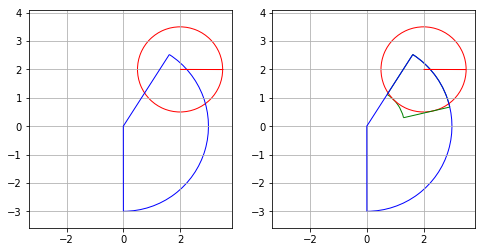

In [8]:
I2 = Interval(0,1.5,0,6.28,origin=(2,2))
I1 = Interval(0,3,-1.57,1,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
# arc_arc(I1.gamma2,I2.gamma2)
fig= plt.figure(figsize = (8,4))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



computation time =  3.2153751850128174


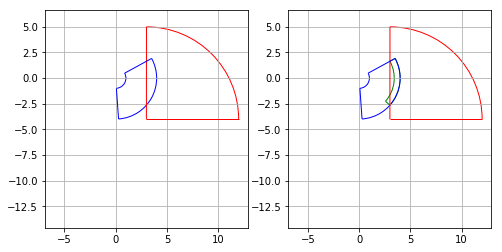

In [9]:
I2 = Interval(0,9,0,1.57,origin=(3,-4))
I1 = Interval(1,4,-1.5,0.5,origin=(0,0))
t0 = time.time()
J = I1.fast_analysis(I2)
t1 = time.time()
print("computation time = ",t1-t0)
# arc_arc(I1.gamma2,I2.gamma2)
fig= plt.figure(figsize = (8,4))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()



In [97]:
ss = [6,6,6,6,8]
ss.append([])
ss

[6, 6, 6, 6, 8, []]

1